In [2]:
import os
import random
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, SpatialDropout1D,
                                     Bidirectional, LSTM, GRU, Dense, Dropout,
                                     BatchNormalization, GlobalAveragePooling1D,
                                     GlobalMaxPooling1D, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import Adam

In [ ]:
VOCAB_SIZE = 10000
MAX_LEN = 200


# Load IMDB dataset

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)
word_index = imdb.get_word_index()

# Pad sequences to fixed length
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (25000, 200), Test shape: (25000, 200)


In [4]:
# save the tokenizer
word_index = imdb.get_word_index()
# shift indices by 3 to account for Keras reserved indices (0: padding, 1:start, 2:OOV)
word_index = {word: (idx + 3) for word, idx in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# create a Tokenizer-like object and attach mappings so you can use it later
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.word_index = word_index
tokenizer.index_word = {idx: word for word, idx in word_index.items()}

with open('tokenizer_3.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

In [5]:
# using FastText embeddings
print("Loading FastText embeddings...")

FASTTEXT_PATH = r"D:\Sentiment Analysis Web App\notebooks\wiki-news-300d-1M-subword.vec"
EMBEDDING_DIM = 300

embeddings_index = {}
with open(FASTTEXT_PATH, "r", encoding="utf-8", errors="ignore") as f:
    first_line = f.readline()
    parts = first_line.split()
    if len(parts) <= 2:
        pass
    else:
        f.seek(0)
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        if coefs.shape[0] == EMBEDDING_DIM:
            embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} FastText word vectors.")


# CREATE EMBEDDING MATRIX

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

print("Embedding matrix shape:", embedding_matrix.shape)

Loading FastText embeddings...
Loaded 999994 FastText word vectors.
Embedding matrix shape: (10000, 300)


In [9]:
# MODEL DEFINITION

def build_model():
    inp = Input(shape=(MAX_LEN,))
    emb = Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_LEN,
                    trainable=True)(inp)

    x = SpatialDropout1D(0.2)(emb)

    # BiLSTM branch
    lstm = Bidirectional(LSTM(32, return_sequences=True, dropout=0.3))(x)
    lstm = Bidirectional(LSTM(16, return_sequences=True, dropout=0.3))(lstm)
    avg_l = GlobalAveragePooling1D()(lstm)
    max_l = GlobalMaxPooling1D()(lstm)

    # BiGRU branch
    gru = Bidirectional(GRU(64, return_sequences=True, dropout=0.3))(x)
    gru = Bidirectional(GRU(32, return_sequences=True, dropout=0.3))(gru)
    avg_g = GlobalAveragePooling1D()(gru)
    max_g = GlobalMaxPooling1D()(gru)

    merged = Concatenate()([avg_l, max_l, avg_g, max_g])
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.4)(merged)
    merged = Dense(64, activation="relu")(merged)
    merged = Dropout(0.3)(merged)
    out = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=inp, outputs=out)
    
    # Compile model
    model.compile(optimizer=Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_model()
model.summary()


# CALLBACKS

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]


# TRAIN MODEL

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs= 10,
    batch_size= 64,
    callbacks=callbacks,
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 300)  │  3,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, 200, 300)  │          0 │ embedding_3[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 200, 64)   │     85,248 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 200, 128)  │    140,544 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 200, 32)   │     10,368 │ bidirectional_8[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 200, 64)   │     31,104 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ bidirectional_9[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ bidirectional_9[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bidirectional_11… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ bidirectional_11… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192)       │        768 │ concatenate_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     24,704 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,301,057 (12.59 MB)

 Trainable params: 3,300,673 (12.59 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 724s 2s/step - accuracy: 0.7175 - loss: 0.5178 - val_accuracy: 0.8628 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.8915 - loss: 0.2696 - val_accuracy: 0.8716 - val_loss: 0.3271 - learning_rate: 0.0010
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9251 - loss: 0.1961 - val_accuracy: 0.8944 - val_loss: 0.2833 - learning_rate: 0.0010
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.9476 - loss: 0.1423 - val_accuracy: 0.8784 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9687 - loss: 0.0905
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
352/352 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.9644 - loss: 0.1009 - val_accuracy: 0.8752 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9809 - loss: 0.054

In [10]:
# evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"model accuracy: {accuracy*100:.2f}%")

782/782 ━━━━━━━━━━━━━━━━━━━━ 157s 201ms/step - accuracy: 0.8778 - loss: 0.3004
model accuracy: 87.78%


In [11]:
# save the model
model.save('sentiment_analysis_model_3.h5')

782/782 ━━━━━━━━━━━━━━━━━━━━ 149s 187ms/step
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



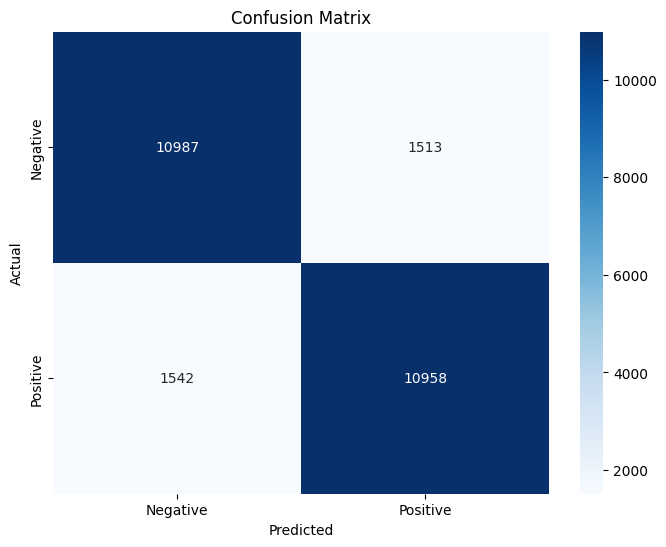

In [12]:
# confusion matrix report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
# --- IGNORE ---
confusion_mtx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()


In [14]:
# testing the model with some example texts

test_texts = [
    "I love this product so much!",
    "This is the worst movie ever.",
    "I hate this terrible thing!",
    "Absolutely fantastic experience!",
    "It's okay, not the best, not the worst.",
    "I am disappointed with the service.",
    "this movie is not good"
]

for text in test_texts:
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)
    pred = model.predict(padded)
    print(f"Text: {text} | Prediction: {pred[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Text: I love this product so much! | Prediction: 0.4532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Text: This is the worst movie ever. | Prediction: 0.0031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Text: I hate this terrible thing! | Prediction: 0.0053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Text: Absolutely fantastic experience! | Prediction: 0.8383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Text: It's okay, not the best, not the worst. | Prediction: 0.0028
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Text: I am disappointed with the service. | Prediction: 0.0167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Text: this movie is not good | Prediction: 0.4820
